# Analyzing Key Indicators of Positive Reviews for iOS Apps 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sklearn as sk
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
from datetime import datetime
import pprint

## Data Source

### https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps

## Import & View Data

In [2]:
apps = pd.read_csv('AppleStore.csv')
apps.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [3]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
Unnamed: 0          7197 non-null int64
id                  7197 non-null int64
track_name          7197 non-null object
size_bytes          7197 non-null int64
currency            7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
rating_count_ver    7197 non-null int64
user_rating         7197 non-null float64
user_rating_ver     7197 non-null float64
ver                 7197 non-null object
cont_rating         7197 non-null object
prime_genre         7197 non-null object
sup_devices.num     7197 non-null int64
ipadSc_urls.num     7197 non-null int64
lang.num            7197 non-null int64
vpp_lic             7197 non-null int64
dtypes: float64(3), int64(9), object(5)
memory usage: 955.9+ KB


### This data set consists of entries for a variety off applications present on the Apple store for iOS. As Apple takes curation of its market place much more seriously than most of its competitors, apps with higher ratings are more commonly featured on both the store landing page and search results. It is for this reason that I intend to discover the most important factors to a high user rating, defined as any score above a 4/5.

## Attribute explanations

### id - The individual ID for each application <br>track_name - The individual title for each application <br>size_bytes - The size of the application <br>currency - The native currency of the application (in this case all USD) <br>price - Cost of the application <br>rating_count_tot - How many ratings the application has received in its lifetime <br>rating_count_ver - How many ratings the application has received for this version <br>user_rating - The aggregate user rating for the applicaton <br>user_rating_ver - The aggregate user rating for the application at its current version <br>ver - The current application version <br>cont_rating - The content rating for the application (4+, 9+, etc) <br>prime_genre - Genre for the application <br>sup_devices.num - Number of devices supported by the application <br>ipadSc_urls.num - Number of screenshots shown on the application page <br>lang.num - Number of supported languages <br>vpp_lic - Whether or not Vpp device based licensing enabled

## Data Cleaning

### I began the process by cleaning the data, removing strings from numeric columns, removing empty columns, and looking for NA values. Next I performed some feature engineering in order to make some continuous variables more accesible. Finally, I created a target dummy variable consisting of a binary indication of whether an application was rated greater than or equal to 4/5.

### Remove empty columns

In [4]:
apps = apps.iloc[:, 1:]

### Rename columns

In [5]:
apps.rename(columns = {'sup_devices.num':'sup_devices', 'ipadSc_urls.num':'ipad_urls', 'lang.num':'lang_num'}, inplace = True)

### Check for NA values

In [6]:
null_columns = apps.columns[apps.isnull().any()]
apps[null_columns].isnull().sum()

Series([], dtype: float64)

### Discretize continuous variables

In [7]:
apps['size_bytes'] = pd.qcut(apps['size_bytes'], 10, duplicates = 'drop')
apps['rating_count_tot'] = pd.qcut(apps['rating_count_tot'], 10, duplicates = 'drop')
apps['sup_devices'] = pd.qcut(apps['sup_devices'], 10, duplicates = 'drop')
apps['lang_num'] = pd.qcut(apps['lang_num'], 10, duplicates = 'drop')

### Cut versions to first number

In [8]:
apps['ver'] = apps['ver'].str.split('.').str[0]

### Remove rows with version numbers that contain text

In [9]:
apps = apps[apps['ver'].str.isnumeric()]

### Group version numbers over 50 into the version number of '50'

In [10]:
apps['ver'] = apps['ver'].astype('int')
apps['ver'][apps['ver'] >= 50] = 50

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [11]:
apps['currency'].unique()

array(['USD'], dtype=object)

### Create dummy variable to indicate if an app is highly rated

In [12]:
apps['target'] = np.where(apps['user_rating'] > 4, 1, 0)

### Check ratio of high vs low rated apps

In [13]:
apps.groupby('target')['target'].count()

target
0    4037
1    3152
Name: target, dtype: int64

### Reset index of data frame

In [14]:
apps.reset_index(drop = True, inplace = True)

### View final data frame

In [15]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 17 columns):
id                  7189 non-null int64
track_name          7189 non-null object
size_bytes          7189 non-null category
currency            7189 non-null object
price               7189 non-null float64
rating_count_tot    7189 non-null category
rating_count_ver    7189 non-null int64
user_rating         7189 non-null float64
user_rating_ver     7189 non-null float64
ver                 7189 non-null int64
cont_rating         7189 non-null object
prime_genre         7189 non-null object
sup_devices         7189 non-null category
ipad_urls           7189 non-null int64
lang_num            7189 non-null category
vpp_lic             7189 non-null int64
target              7189 non-null int64
dtypes: category(4), float64(3), int64(6), object(4)
memory usage: 758.7+ KB


In [16]:
apps.head()

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices,ipad_urls,lang_num,vpp_lic,target
0,281656475,PAC-MAN Premium,"(97153024.0, 120458035.2]",USD,3.99,"(18277.8, 2974676.0]",26,4.0,4.5,6,4+,Games,"(37.0, 38.0]",5,"(5.0, 10.0]",1,0
1,281796108,Evernote - stay organized,"(154900889.6, 219630592.0]",USD,0.00,"(18277.8, 2974676.0]",26,4.0,3.5,8,4+,Productivity,"(8.999, 37.0]",5,"(15.0, 75.0]",1,0
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts","(97153024.0, 120458035.2]",USD,0.00,"(18277.8, 2974676.0]",2822,3.5,4.5,5,4+,Weather,"(8.999, 37.0]",5,"(2.0, 5.0]",1,0
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...","(120458035.2, 154900889.6]",USD,0.00,"(18277.8, 2974676.0]",649,4.0,4.5,5,12+,Shopping,"(8.999, 37.0]",5,"(5.0, 10.0]",1,0
4,282935706,Bible,"(75460812.8, 97153024.0]",USD,0.00,"(18277.8, 2974676.0]",5320,4.5,5.0,7,4+,Reference,"(8.999, 37.0]",5,"(15.0, 75.0]",1,1


### Having cleaned the data and viewed the final product, I then moved on to exploring the data and asking some analytical questions. Three of the more interesting ones (and their results) are as follows.

## Question I: Do expensive apps tend to receive high ratings?

### Create columns for apps that scored high and apps that scored low

In [17]:
apps_high = apps[apps['target'] == 1]
apps_low = apps[apps['target'] == 0]

### Get count of each price point by the amount of high and low rated apps and view the results

In [18]:
y_tab = apps_high[['price', 'target']]
y_tab['tot_high'] = apps_high['price'].groupby(apps_high['price']).transform('size')
y_tab = y_tab.sort_values(by = ['tot_high'], ascending = False)
y_tab = y_tab.drop_duplicates(keep = 'first')
y_tab = y_tab.reset_index()
y_tab.head()

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,index,price,target,tot_high
0,4,0.00,1,1717
1,2289,2.99,1,330
2,1110,0.99,1,313
3,684,1.99,1,268
4,3442,4.99,1,185


In [19]:
n_tab = apps_low[['price', 'target']]
n_tab['tot_low'] = apps_low['price'].groupby(apps_low['price']).transform('size')
n_tab = n_tab.sort_values(by = ['tot_low'], ascending = False)
n_tab = n_tab.drop_duplicates(keep = 'first')
n_tab = n_tab.reset_index()
n_tab.head()

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,index,price,target,tot_low
0,6155,0.00,0,2332
1,7146,0.99,0,415
2,6617,2.99,0,353
3,3142,1.99,0,352
4,1848,4.99,0,209


### Create new ratio table from previous tables, engineer percentage of success by dividing the total of high rated apps by low rated apps


In [20]:
ratio_tab = y_tab
ratio_tab['tot_low'] = n_tab['tot_low']
ratio_tab['percent'] = ratio_tab['tot_high'] / (ratio_tab['tot_high'] + ratio_tab['tot_low'])
ratio_tab.drop(['index'], axis = 1, inplace = True)
ratio_tab.head()

,price,target,tot_high,tot_low,percent
0,0.00,1,1717,2332,0.424055
1,2.99,1,330,415,0.442953
2,0.99,1,313,353,0.469970
3,1.99,1,268,352,0.432258
4,4.99,1,185,209,0.469543


### Add in application price points that only recieved low reviews and replace resulting NA values with 0's

In [21]:
add_low = apps['price'][~apps['price'].isin(y_tab['price'])].unique()

In [22]:
ratio_tab = ratio_tab.append(pd.DataFrame(add_low, columns = ['price']),ignore_index = True)
ratio_tab.fillna(0, inplace = True)
ratio_tab

/Users/Ryan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,percent,price,target,tot_high,tot_low
0,0.424055,0.00,1.0,1717.0,2332.0
1,0.442953,2.99,1.0,330.0,415.0
2,0.469970,0.99,1.0,313.0,353.0
3,0.432258,1.99,1.0,268.0,352.0
4,0.469543,4.99,1.0,185.0,209.0
5,0.505415,3.99,1.0,140.0,137.0
6,0.493976,6.99,1.0,82.0,84.0
7,0.382716,9.99,1.0,31.0,50.0
8,0.500000,5.99,1.0,26.0,26.0
9,0.303030,7.99,1.0,10.0,23.0


### Plot the results

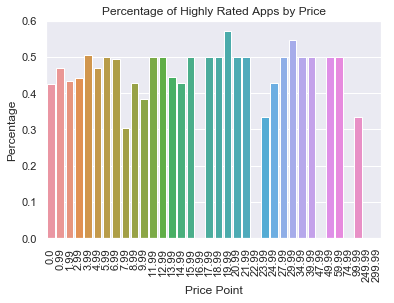

In [23]:
sns.set()
p_plot = sns.barplot(ratio_tab['price'], ratio_tab['percent'])
p_plot.set_xticklabels(p_plot.get_xticklabels(), rotation = 90);
plt.title('Percentage of Highly Rated Apps by Price')
p_plot.set(xlabel = 'Price Point', ylabel = 'Percentage')
plt.show()

### As we can see, every price point with the exception of 3.99, 19.99, and 29.99 contain below 50% of ratings of above 4. There are also some outliers, such as the 299.99 point, which contains only a single application, that sole low rating resulting in a 0% score for the whole price.

## Question II: What genre has the highest percentage of highly rated apps?

### Get count of each genre by amount of high and low rated apps and view the results

In [24]:
y_tab = apps_high[['prime_genre', 'target']]
y_tab['tot_high'] = apps_high['prime_genre'].groupby(apps_high['prime_genre']).transform('size')
y_tab = y_tab.sort_values(by = ['tot_high'], ascending = False)
y_tab = y_tab.drop_duplicates(keep = 'first')
y_tab = y_tab.reset_index()
y_tab.head()

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,index,prime_genre,target,tot_high
0,3264,Games,1,1940
1,4280,Photo & Video,1,184
2,5094,Education,1,158
3,1406,Entertainment,1,142
4,6415,Health & Fitness,1,105


In [25]:
n_tab = apps_low[['prime_genre', 'target']]
n_tab['tot_low'] = apps_low['prime_genre'].groupby(apps_low['prime_genre']).transform('size')
n_tab = n_tab.sort_values(by = ['tot_low'], ascending = False)
n_tab = n_tab.drop_duplicates(keep = 'first')
n_tab = n_tab.reset_index()
n_tab.head()

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,index,prime_genre,target,tot_low
0,0,Games,0,1919
1,6072,Entertainment,0,390
2,5659,Education,0,295
3,7151,Utilities,0,174
4,811,Photo & Video,0,165


### Create new ratio table from previous tables, engineer percentage of success by dividing the total of high rated apps by low rated apps


In [26]:
ratio_tab = y_tab
ratio_tab['tot_low'] = n_tab['tot_low']
ratio_tab['percent'] = ratio_tab['tot_high'] / (ratio_tab['tot_high'] + ratio_tab['tot_low'])
ratio_tab.drop(['index'], axis = 1, inplace = True)
ratio_tab = ratio_tab.sort_values(by = ['percent'], ascending = False)
ratio_tab

,prime_genre,target,tot_high,tot_low,percent
21,Medical,1,13,10,0.565217
0,Games,1,1940,1919,0.502721
3,Entertainment,1,142,174,0.449367
5,Productivity,1,91,126,0.419355
7,Music,1,64,92,0.410256
6,Utilities,1,74,107,0.408840
4,Health & Fitness,1,105,165,0.388889
8,Shopping,1,53,87,0.378571
18,Sports,1,21,35,0.375000
9,Book,1,44,80,0.354839


### Plot the results

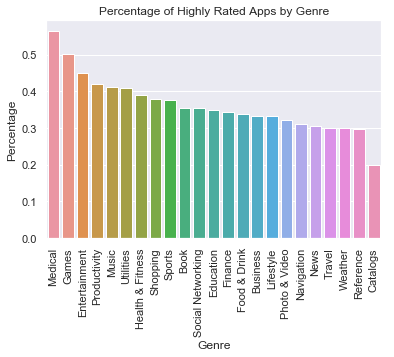

In [27]:
sns.set()
p_plot = sns.barplot(ratio_tab['prime_genre'], ratio_tab['percent'])
p_plot.set_xticklabels(p_plot.get_xticklabels(), rotation = 90);
plt.title('Percentage of Highly Rated Apps by Genre')
p_plot.set(xlabel = 'Genre', ylabel = 'Percentage')
plt.show()

### It appears as though nearly all application categories predominantly consist of applications rated at 4 or below, the exception being the 'Medical' category. On the other end of the spectrum, 'Catelogs' has the lowest rating with only ~20% of applications being highly rated.

## Question III: Do apps with more reviews receive higher ratings?

### Get count of each review count bin by amount of high and low rated apps and view the results

In [28]:
y_tab = apps_high[['rating_count_tot', 'target']]
y_tab['tot_high'] = apps_high['rating_count_tot'].groupby(apps_high['rating_count_tot']).transform('size')
y_tab = y_tab.sort_values(by = ['tot_high'], ascending = False)
y_tab = y_tab.drop_duplicates(keep = 'first')
y_tab = y_tab.reset_index()
y_tab.head()

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,index,rating_count_tot,target,tot_high
0,4,"(18277.8, 2974676.0]",1,494
1,690,"(4782.6, 18277.8]",1,482
2,262,"(1730.4, 4782.6]",1,455
3,1527,"(729.0, 1730.4]",1,411
4,1667,"(300.0, 729.0]",1,313


In [29]:
n_tab = apps_low[['rating_count_tot', 'target']]
n_tab['tot_low'] = apps_low['rating_count_tot'].groupby(apps_low['rating_count_tot']).transform('size')
n_tab = n_tab.sort_values(by = ['tot_low'], ascending = False)
n_tab = n_tab.drop_duplicates(keep = 'first')
n_tab = n_tab.reset_index()
n_tab.head()

/Users/Ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,index,rating_count_tot,target,tot_low
0,7183,"(-0.001, 12.0]",0,1238
1,3942,"(51.0, 124.0]",0,473
2,6851,"(12.0, 51.0]",0,458
3,6720,"(124.0, 300.0]",0,430
4,5693,"(300.0, 729.0]",0,404


### Create new ratio table from previous tables, engineer percentage of success by dividing the total of high rated apps by low rated apps


In [30]:
ratio_tab = y_tab
ratio_tab['tot_low'] = n_tab['tot_low']
ratio_tab['percent'] = ratio_tab['tot_high'] / (ratio_tab['tot_high'] + ratio_tab['tot_low'])
ratio_tab.drop(['index'], axis = 1, inplace = True)
ratio_tab

,rating_count_tot,target,tot_high,tot_low,percent
0,"(18277.8, 2974676.0]",1,494,1238,0.285219
1,"(4782.6, 18277.8]",1,482,473,0.504712
2,"(1730.4, 4782.6]",1,455,458,0.498357
3,"(729.0, 1730.4]",1,411,430,0.488704
4,"(300.0, 729.0]",1,313,404,0.436541
5,"(124.0, 300.0]",1,287,308,0.482353
6,"(12.0, 51.0]",1,255,264,0.491329
7,"(51.0, 124.0]",1,246,237,0.509317
8,"(-0.001, 12.0]",1,209,225,0.481567


### Plot the results

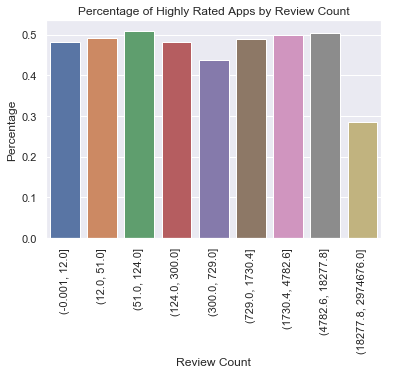

In [31]:
sns.set()
p_plot = sns.barplot(ratio_tab['rating_count_tot'], ratio_tab['percent'])
p_plot.set_xticklabels(p_plot.get_xticklabels(), rotation = 90);
plt.title('Percentage of Highly Rated Apps by Review Count')
p_plot.set(xlabel = 'Review Count', ylabel = 'Percentage')
plt.show()

### There appears to be no consistent trend in regard to review count vs review score. However, it is worth noting the dip between the bins ranging from 51 - 729 and the sharp decrease in rating for the final bin, significantly lower than all of the rest at only 28.5% of apps with a high rating. 

### Having investigated the data, I now felt prepared to begin the process of predictive modeling. Using the Logistic Regression and Random Forest algorithms, I will now predict which apps will recieve a rating of above 4 utilizing the other available variables.

## Predictive Modeling

### Encode data

In [32]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 17 columns):
id                  7189 non-null int64
track_name          7189 non-null object
size_bytes          7189 non-null category
currency            7189 non-null object
price               7189 non-null float64
rating_count_tot    7189 non-null category
rating_count_ver    7189 non-null int64
user_rating         7189 non-null float64
user_rating_ver     7189 non-null float64
ver                 7189 non-null int64
cont_rating         7189 non-null object
prime_genre         7189 non-null object
sup_devices         7189 non-null category
ipad_urls           7189 non-null int64
lang_num            7189 non-null category
vpp_lic             7189 non-null int64
target              7189 non-null int64
dtypes: category(4), float64(3), int64(6), object(4)
memory usage: 758.7+ KB


### Drop unused columns

In [33]:
apps = apps.drop('id', 1)
apps = apps.drop('track_name', 1)
apps = apps.drop('currency', 1)
apps = apps.drop('user_rating', 1)

### Encode necessary columns

In [34]:
apps['cont_rating'] = apps['cont_rating'].astype('category').cat.codes
apps['prime_genre'] = apps['prime_genre'].astype('category').cat.codes
apps['size_bytes'] = apps['size_bytes'].astype('category').cat.codes
apps['rating_count_tot'] = apps['rating_count_tot'].astype('category').cat.codes
apps['sup_devices'] = apps['sup_devices'].astype('category').cat.codes
apps['lang_num'] = apps['lang_num'].astype('category').cat.codes

### Check results

In [35]:
apps.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,sup_devices,ipad_urls,lang_num,vpp_lic,target
0,5,3.99,8,26,4.5,6,2,7,1,5,3,1,0
1,7,0.00,8,26,3.5,8,2,15,0,5,5,1,0
2,5,0.00,8,2822,4.5,5,2,22,0,5,2,1,0
3,6,0.00,8,649,4.5,5,0,17,0,5,3,1,0
4,4,0.00,8,5320,5.0,7,2,16,0,5,5,1,1


In [36]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 13 columns):
size_bytes          7189 non-null int8
price               7189 non-null float64
rating_count_tot    7189 non-null int8
rating_count_ver    7189 non-null int64
user_rating_ver     7189 non-null float64
ver                 7189 non-null int64
cont_rating         7189 non-null int8
prime_genre         7189 non-null int8
sup_devices         7189 non-null int8
ipad_urls           7189 non-null int64
lang_num            7189 non-null int8
vpp_lic             7189 non-null int64
target              7189 non-null int64
dtypes: float64(2), int64(5), int8(6)
memory usage: 435.3 KB


### Split data into train and test sets

In [37]:
X = apps.iloc[:, 0:12].values
y = apps.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 151)

### Create Logistic Regression model

In [38]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 151)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred

/Users/Ryan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



array([1, 0, 0, ..., 0, 1, 1])

### Print model accuracy

In [39]:
from sklearn import metrics

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.7787610619469026


### Check model precision and recall

In [40]:
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))

Precision:  0.700395256916996
Recall:  0.8585271317829457


### Check model confusion matrix

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[962, 379],
       [146, 886]])

### With a simple Logistic Regression model, we can achieve an already respectable accuracy of 77.5%. Now let's see how the Random Forest model performs.

### Create Random Forest model

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 1000)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Check model accuracy

In [43]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.8158449220396123


### Check model precision and recall

In [44]:
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))

Precision:  0.7825261158594492
Recall:  0.7984496124031008


### Check model confusion matrix

In [45]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1112,  229],
       [ 208,  824]])

### The Random Forest model performs marginally better, resulting in an accuracy of 81.4%. Now we can take a look at the feature importance rankings and gain some insight into our variables while refining the model as well.

### Determine feature importance

In [46]:
feature_names = list(apps.drop(['target'], axis = 1).columns)
feature_imp = pd.Series(clf.feature_importances_, index = feature_names).sort_values(ascending = False)
feature_imp

user_rating_ver     0.324179
rating_count_ver    0.155807
rating_count_tot    0.113165
size_bytes          0.079921
prime_genre         0.064296
ver                 0.055221
price               0.052272
lang_num            0.049593
sup_devices         0.036239
cont_rating         0.035135
ipad_urls           0.032803
vpp_lic             0.001369
dtype: float64

### Plot results

No handles with labels found to put in legend.


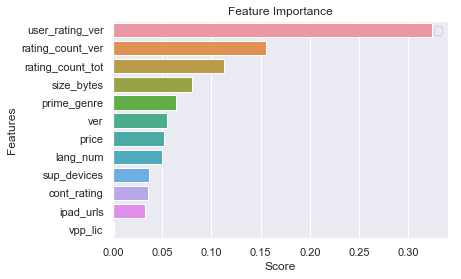

In [47]:
%matplotlib inline
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.legend()
plt.show()

### Interestingly, it appears as though user_rating_ver is the most significant variable by far, seeming to indicate that the rating for the app's current version is likely to reflect its overall rating as well. rating_count_ver and rating_count_tot are next in line, unsurprisingly indicating that the variables most directly related to ratings are the most significant in determining the overall rating.

## Results

### It appears as though high application ratings are (unsurprisingly) predominantly determined by those variables most closely related to rating (user_rating_ver, rating_count_ver, and rating_count_tot). With a resulting accuracy of 81.6%, the Random Forest model appears to be relatively adept at classifying these cases and could definitely be useful for interested application developers. In regard to price, it appears as though it is generally negligible in consideration of rating. However, app category definitely has an important impact, with 'Medical' containing the most positively rated apps and 'Catelogs' the least. Finally, review count tends to be relatively consistent in its relation to rating up until the final discretization bucket of ~18,000 +. This is particularly interesting as it suggests that apps in this highest range of reviews, which are likely more popular in general, tend to receive worse reviews overall. <br><br>Overall it appears as though this endeavor has been a success. Through the steps of exploratory data analysis, to data cleaning, to analysis, and finally, predictive modeling, I have both determined important indicators of high ratings, their relationship to ratings, and built a respectable predictive model.